In [48]:
import os
import itertools
import json
import numpy as np
import pandas as pd
import seaborn as sns
from data_handler import DataHandler
from typing import List, Tuple, Dict, Set

## utility functions

In [49]:
def initialize_components(component_num: int) -> Tuple[str]:
    stack = []
    alphabet = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ') * int(np.ceil(component_num/26))
    for n in range(component_num):
        it = int(np.floor(n/26))
        stack.append('{}.{}'.format(alphabet[n], it+1))
    return tuple(stack)

def aggregate_episode_samples(df):
    agg_samples = []
    episodes = df.episode.unique()
    for e in episodes:
        single_episode_samples = df[df['episode'] == e]
        
        concat_trajectories = ''
        reward_sum = 0
        for _, row in single_episode_samples.iterrows():
            source = row.source
            action = row.action
            target = row.target
            reward_sum += row.reward
            
            concat_trajectories += '{{{}->{}->{}}},'.format(source, action, target)
        agg_samples.append({
            'episode': e,
            'trajectories': concat_trajectories,
            'reward_sum': reward_sum,
            'reward_mean':  reward_sum / len(single_episode_samples)
        })
        
    agg_samples_df = pd.DataFrame(agg_samples)
    return agg_samples_df

## Markov Chain

In [50]:
class MarkovChain:
    def __init__(self):
        self.seen_states: Set = set()
        self.states: List[Dict] = []
        self.links: List[Dict] = []
        self.unhandled_permutations = []
        self.action_reward_map = {
            'swap': -2.0,
            'repair': -1.0,
            'end': 0
        }

    def __permutate(self, state: Tuple[str]) -> Dict:
        permutations = [tuple(perm) for perm in itertools.permutations(state)]
        return {'source': state, 'permutations': permutations}

    def __repair(self, state: Tuple[str]) -> Tuple[str]:
        temp_state = list(state)
        temp_state.pop(0)
        return tuple(temp_state)

    def __deduplicate(self, l: List[Dict]) -> List[Dict]:
        #return list(li for li, _ in itertools.groupby(obj_list))
        return [dict(t) for t in {tuple(d.items()) for d in l}]

    def reset(self) -> None:
        self.seen_states = set()
        self.states = []
        self.links = []
        self.unhandled_permutations = []

    def create(self, component_tuple: Tuple[str]) -> None:
        self.reset()
        self.unhandled_permutations.append(self.__permutate(component_tuple))
        while len(self.unhandled_permutations) > 0:
            for i, permutated_obj in enumerate(self.unhandled_permutations):
                source_state: List[str] = list(permutated_obj['source'])
                permutation_states: List[List[str]] = list(permutated_obj['permutations'])

                if len(source_state) > 0:
                    # process source state
                    repaired_source = self.__repair(source_state)

                    self.states.append({'name': tuple(source_state)})
                    if len(source_state) == 1:
                        self.links.append({'source': tuple(source_state),
                                           'action': 'end',
                                           'target': tuple(source_state),
                                           'probability': 1 / len(permutation_states),
                                           'reward': self.action_reward_map['end']
                                          })
                    else:
                        self.links.append({'source': tuple(source_state),
                                           'action': 'repair',
                                           'target': tuple(repaired_source),
                                           'probability': 1 / len(permutation_states),
                                           'reward': self.action_reward_map['repair']
                                          })

                    repaired_source_permutations = self.__permutate(repaired_source)
                    self.unhandled_permutations.append(repaired_source_permutations)

                    for permutated_state in permutation_states[1:]:
                        self.seen_states.add(tuple(permutated_state))
                        
                        self.states.append({'name': tuple(permutated_state)})
                        self.links.append({'source': tuple(source_state),
                                           'action': 'swap',
                                           'target': tuple(permutated_state),
                                           'probability': 1 / len(permutation_states),
                                           'reward': self.action_reward_map['swap']
                                          })

                        repaired_permutated_state = self.__repair(permutated_state)
                        repaired_permutated_state_permutations = self.__permutate(repaired_permutated_state)
                        self.unhandled_permutations.append(repaired_permutated_state_permutations)
                        
                        permutated_state_permutations = self.__permutate(permutated_state)
                        permutated_state_permutations['permutations'] = [perm for perm in permutated_state_permutations['permutations'] if tuple(perm) not in self.seen_states]
                        
                        if len(permutated_state_permutations['permutations']) > 0:
                            self.unhandled_permutations.append(permutated_state_permutations)
                
                self.seen_states.add(tuple(source_state))
                self.unhandled_permutations.remove(permutated_obj)
        self.states = self.__deduplicate(self.states)
        self.links = self.__deduplicate(self.links)
        self.create_transition_matrix()
        self.create_action_space()
        
    def create_transition_matrix(self) -> pd.DataFrame:
        state_names = [str(state['name']) for state in self.states]
        self.transition_matrix = pd.DataFrame(np.zeros((len(state_names), len(state_names))))
        self.transition_matrix.index = state_names
        self.transition_matrix.columns = state_names
        
        for link in self.links:
            row = str(link['source'])
            col = str(link['target'])
            val = link['probability']
    
            self.transition_matrix.loc[row, col] = val
        
        return self.transition_matrix
    
    def create_action_space(self) -> pd.DataFrame:
        links = []
        for link in list(self.links):
            link['source'] = str(link['source'])
            link['target'] = str(link['target'])
            links.append(link)
        self.action_space = pd.DataFrame(links)
        
        return self.action_space
        
    def to_json(self, state_file_path='states.json', link_file_path='links.json') -> None:
        print('Dump states...')
        with open(state_file_path, 'w') as f:
            json.dump(self.states, f)
        
        print('Dump links...')
        with open(link_file_path, 'w') as f:
            json.dump(self.links, f)
        
        print('Done!')
        
    def set_action_reward_map(self, action_reward_map: Dict) -> None:
        self.action_reward_map = action_reward_map
        for link in self.links:
            link['reward'] =  self.action_reward_map[link['action']]
        
        self.create_action_space()
        
    def sample(self, source_state: str, episodes: int):
        samples = []
        for i in range(episodes):
            self.make_action(source_state, i, samples)
        
        return pd.DataFrame(samples)
            
        
    def make_action(self, source_state: str, episode: int, l: List):
        possible_actions = self.action_space[self.action_space['source'] == source_state]
        taken_action = possible_actions.sample(1, weights=possible_actions.probability).iloc[0]
        taken_action['episode'] = episode
        l.append(taken_action)

        target_state = taken_action.target
        reward = taken_action.reward

        if reward == 0:
            return
        else:
            self.make_action(target_state, episode, l)

In [51]:
dh = DataHandler()
components = tuple(dh.get_sample_component_failure_pairs(3))
components

(('Buy Now Item Filter', 'CF5'),
 ('Item Management Service', 'CF3'),
 ('Query Service', 'CF3'))

In [35]:
components = initialize_components(3)
components

('A.1', 'B.1', 'C.1')

In [52]:
mcp = MarkovChain()
mcp.create(components)

## Transition Matrix

In [53]:
mcp.create_transition_matrix()

,"(('Buy Now Item Filter', 'CF5'), ('Item Management Service', 'CF3'), ('Query Service', 'CF3'))","(('Query Service', 'CF3'), ('Item Management Service', 'CF3'), ('Buy Now Item Filter', 'CF5'))","(('Buy Now Item Filter', 'CF5'), ('Item Management Service', 'CF3'))","(('Item Management Service', 'CF3'), ('Query Service', 'CF3'), ('Buy Now Item Filter', 'CF5'))","(('Item Management Service', 'CF3'), ('Buy Now Item Filter', 'CF5'), ('Query Service', 'CF3'))","(('Item Management Service', 'CF3'), ('Buy Now Item Filter', 'CF5'))","(('Buy Now Item Filter', 'CF5'),)","(('Item Management Service', 'CF3'),)","(('Buy Now Item Filter', 'CF5'), ('Query Service', 'CF3'), ('Item Management Service', 'CF3'))","(('Item Management Service', 'CF3'), ('Query Service', 'CF3'))","(('Query Service', 'CF3'), ('Buy Now Item Filter', 'CF5'))","(('Query Service', 'CF3'),)","(('Query Service', 'CF3'), ('Item Management Service', 'CF3'))","(('Buy Now Item Filter', 'CF5'), ('Query Service', 'CF3'))","(('Query Service', 'CF3'), ('Buy Now Item Filter', 'CF5'), ('Item Management Service', 'CF3'))"
"(('Buy Now Item Filter', 'CF5'), ('Item Management Service', 'CF3'), ('Query Service', 'CF3'))",0.000000,0.166667,0.0,0.166667,0.166667,0.0,0.0,0.0,0.166667,0.166667,0.000000,0.0,0.0,0.00,0.166667
"(('Query Service', 'CF3'), ('Item Management Service', 'CF3'), ('Buy Now Item Filter', 'CF5'))",0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000
"(('Buy Now Item Filter', 'CF5'), ('Item Management Service', 'CF3'))",0.000000,0.000000,0.0,0.000000,0.000000,0.5,0.0,0.5,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000
"(('Item Management Service', 'CF3'), ('Query Service', 'CF3'), ('Buy Now Item Filter', 'CF5'))",0.333333,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.333333,0.0,0.0,0.00,0.333333
"(('Item Management Service', 'CF3'), ('Buy Now Item Filter', 'CF5'), ('Query Service', 'CF3'))",0.250000,0.250000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.25,0.250000
"(('Item Management Service', 'CF3'), ('Buy Now Item Filter', 'CF5'))",0.000000,0.000000,0.5,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000
"(('Buy Now Item Filter', 'CF5'),)",0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000
"(('Item Management Service', 'CF3'),)",0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000
"(('Buy Now Item Filter', 'CF5'), ('Query Service', 'CF3'), ('Item Management Service', 'CF3'))",0.000000,0.200000,0.0,0.200000,0.200000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.2,0.00,0.200000
"(('Item Management Service', 'CF3'), ('Query Service', 'CF3'))",0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.5,0.5,0.00,0.000000


## Action Space

In [54]:
mcp.create_action_space()

,source,action,target,probability,reward
0,"(('Buy Now Item Filter', 'CF5'), ('Item Manage...",swap,"(('Item Management Service', 'CF3'), ('Buy Now...",0.166667,-2.0
1,"(('Buy Now Item Filter', 'CF5'), ('Item Manage...",swap,"(('Item Management Service', 'CF3'), ('Query S...",0.166667,-2.0
2,"(('Query Service', 'CF3'), ('Buy Now Item Filt...",repair,"(('Buy Now Item Filter', 'CF5'), ('Item Manage...",0.500000,-1.0
3,"(('Buy Now Item Filter', 'CF5'),)",end,"(('Buy Now Item Filter', 'CF5'),)",1.000000,0.0
4,"(('Query Service', 'CF3'), ('Item Management S...",repair,"(('Item Management Service', 'CF3'), ('Buy Now...",1.000000,-1.0
5,"(('Item Management Service', 'CF3'), ('Query S...",swap,"(('Query Service', 'CF3'), ('Item Management S...",0.500000,-2.0
6,"(('Buy Now Item Filter', 'CF5'), ('Query Servi...",swap,"(('Query Service', 'CF3'), ('Item Management S...",0.200000,-2.0
7,"(('Query Service', 'CF3'), ('Buy Now Item Filt...",repair,"(('Buy Now Item Filter', 'CF5'),)",0.500000,-1.0
8,"(('Item Management Service', 'CF3'), ('Buy Now...",swap,"(('Query Service', 'CF3'), ('Item Management S...",0.250000,-2.0
9,"(('Query Service', 'CF3'), ('Item Management S...",swap,"(('Item Management Service', 'CF3'), ('Query S...",0.500000,-2.0


## Sample

In [57]:
samples = mcp.sample(str(components), 100)
samples

,source,action,target,probability,reward,episode
29,"(('Buy Now Item Filter', 'CF5'), ('Item Manage...",swap,"(('Query Service', 'CF3'), ('Item Management S...",0.166667,-2.0,0
4,"(('Query Service', 'CF3'), ('Item Management S...",repair,"(('Item Management Service', 'CF3'), ('Buy Now...",1.000000,-1.0,0
32,"(('Item Management Service', 'CF3'), ('Buy Now...",repair,"(('Buy Now Item Filter', 'CF5'),)",1.000000,-1.0,0
3,"(('Buy Now Item Filter', 'CF5'),)",end,"(('Buy Now Item Filter', 'CF5'),)",1.000000,0.0,0
0,"(('Buy Now Item Filter', 'CF5'), ('Item Manage...",swap,"(('Item Management Service', 'CF3'), ('Buy Now...",0.166667,-2.0,1
...,...,...,...,...,...,...
18,"(('Item Management Service', 'CF3'), ('Buy Now...",swap,"(('Query Service', 'CF3'), ('Buy Now Item Filt...",0.250000,-2.0,99
2,"(('Query Service', 'CF3'), ('Buy Now Item Filt...",repair,"(('Buy Now Item Filter', 'CF5'), ('Item Manage...",0.500000,-1.0,99
25,"(('Buy Now Item Filter', 'CF5'), ('Item Manage...",swap,"(('Item Management Service', 'CF3'), ('Buy Now...",0.500000,-2.0,99
32,"(('Item Management Service', 'CF3'), ('Buy Now...",repair,"(('Buy Now Item Filter', 'CF5'),)",1.000000,-1.0,99


## Aggregated Samples

In [58]:
agg_samples = aggregate_episode_samples(samples)
agg_samples

,episode,trajectories,reward_sum,reward_mean
0,0,"{(('Buy Now Item Filter', 'CF5'), ('Item Manag...",-4.0,-1.000000
1,1,"{(('Buy Now Item Filter', 'CF5'), ('Item Manag...",-8.0,-1.333333
2,2,"{(('Buy Now Item Filter', 'CF5'), ('Item Manag...",-8.0,-1.333333
3,3,"{(('Buy Now Item Filter', 'CF5'), ('Item Manag...",-10.0,-1.428571
4,4,"{(('Buy Now Item Filter', 'CF5'), ('Item Manag...",-6.0,-1.200000
...,...,...,...,...
95,95,"{(('Buy Now Item Filter', 'CF5'), ('Item Manag...",-6.0,-1.200000
96,96,"{(('Buy Now Item Filter', 'CF5'), ('Item Manag...",-14.0,-1.555556
97,97,"{(('Buy Now Item Filter', 'CF5'), ('Item Manag...",-10.0,-1.428571
98,98,"{(('Buy Now Item Filter', 'CF5'), ('Item Manag...",-4.0,-1.000000


In [59]:
mean = agg_samples.reward_sum.mean()
mean

-6.8

## Plot samples

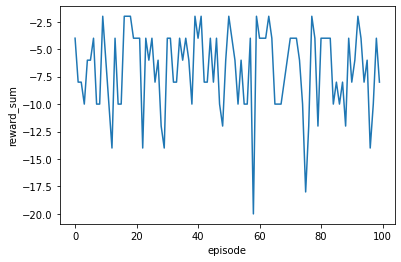

In [60]:
sns.lineplot(x=agg_samples.episode, y=agg_samples.reward_sum)